# Calculate vorticity

In [1]:
# imports
from importlib import reload
import os

import xarray

import numpy as np
# import fsspec
import matplotlib
import matplotlib.pyplot as plt
import gsw_xarray as gsw
from xhistogram.xarray import histogram

from dask.diagnostics import ProgressBar

from strucFunct2_ai import timescale

from profiler import gliderdata
from profiler import profilerpairs
from cugn import io as cugn_io
from cugn import utils as cugn_utils
from cugn import plotting as cugn_plotting

import qg_utils

# Load up

In [2]:
qg, mSF_15 = qg_utils.load_qg()

In [3]:
qg

<xarray.Dataset> Size: 23GB
Dimensions:  (time: 7200, lev: 2, y: 256, x: 256, lev_mid: 1, l: 256, k: 129)
Coordinates:
  * time     (time) float64 58kB 0.0 8.64e+04 1.728e+05 ... 6.219e+08 6.22e+08
  * lev      (lev) int64 16B 1 2
  * lev_mid  (lev_mid) float64 8B 1.5
  * x        (x) float64 2kB 1.953e+03 5.859e+03 ... 9.941e+05 9.98e+05
  * y        (y) float64 2kB 1.953e+03 5.859e+03 ... 9.941e+05 9.98e+05
  * l        (l) float64 2kB 0.0 6.283e-06 1.257e-05 ... -1.257e-05 -6.283e-06
  * k        (k) float64 1kB 0.0 6.283e-06 1.257e-05 ... 0.000798 0.0008042
Data variables:
    q        (time, lev, y, x) float64 8GB ...
    u        (time, lev, y, x) float64 8GB ...
    v        (time, lev, y, x) float64 8GB ...
Attributes: (12/23)
    pyqg:beta:       1.5e-11
    pyqg:delta:      0.25
    pyqg:del2:       0.8
    pyqg:dt:         3600.0
    pyqg:filterfac:  23.6
    pyqg:L:          1000000.0
    ...              ...
    pyqg:tc:         0
    pyqg:tmax:       622080000.0
    pyqg:twrite:     10000
    pyqg:W:          1000000.0
    title:           pyqg: Python Quasigeostrophic Model
    reference:       https://pyqg.readthedocs.io/en/latest/index.html

In [4]:
qg.q

<xarray.DataArray 'q' (time: 7200, lev: 2, y: 256, x: 256)> Size: 8GB
[943718400 values with dtype=float64]
Coordinates:
  * time     (time) float64 58kB 0.0 8.64e+04 1.728e+05 ... 6.219e+08 6.22e+08
  * lev      (lev) int64 16B 1 2
  * x        (x) float64 2kB 1.953e+03 5.859e+03 ... 9.941e+05 9.98e+05
  * y        (y) float64 2kB 1.953e+03 5.859e+03 ... 9.941e+05 9.98e+05
Attributes:
    units:      s^-1
    long_name:  potential vorticity in real space

In [23]:
qg.y

<xarray.DataArray 'y' (y: 256)> Size: 2kB
array([  1953.125,   5859.375,   9765.625, ..., 990234.375, 994140.625,
       998046.875])
Coordinates:
  * y        (y) float64 2kB 1.953e+03 5.859e+03 ... 9.941e+05 9.98e+05
Attributes:
    long_name:  real space grid points in the y direction
    units:      grid point

# Plot potential vorticity

In [11]:
q0 = qg.q.isel(time=0, lev=0)
q1000 = qg.q.isel(time=1000, lev=0)
q0

<xarray.DataArray 'q' (y: 256, x: 256)> Size: 524kB
[65536 values with dtype=float64]
Coordinates:
    time     float64 8B 0.0
    lev      int64 8B 1
  * x        (x) float64 2kB 1.953e+03 5.859e+03 ... 9.941e+05 9.98e+05
  * y        (y) float64 2kB 1.953e+03 5.859e+03 ... 9.941e+05 9.98e+05
Attributes:
    units:      s^-1
    long_name:  potential vorticity in real space

## Plot

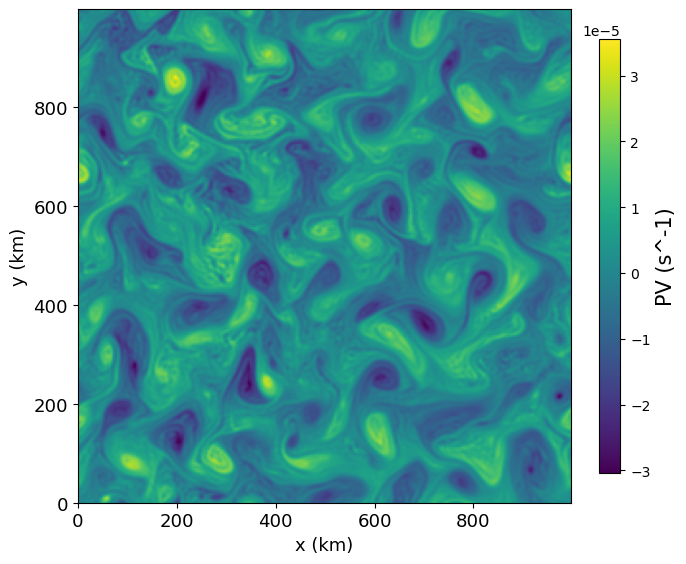

In [42]:
fig = plt.figure(figsize=(7,7))
ax = plt.gca()

#ax.imshow(q0)
img = ax.imshow(q1000, origin='lower',
                extent=[0, qg.x.data[-1]*1e-3, 0, qg.x.data[-1]*1e-3])
cbaxes = plt.colorbar(img, pad=0.05, fraction=0.040)
cbaxes.set_label('PV (s^-1)', fontsize=15.)
#
ax.set_xlabel('x (km)')
ax.set_ylabel('y (km)')
#    cbaxes.ax.tick_params(labelsize=csz)
cugn_plotting.set_fontsize(ax, 13)
plt.show()

## Zoom in

In [30]:
inner400 = np.where((qg.x >= 400*1e3) & (qg.x < 500.*1e3))[0]
xval = qg.x[inner400]

In [38]:
q1000.data[inner400[0]:inner400[-1],inner400[0]:inner400[-1]]

(25, 25)

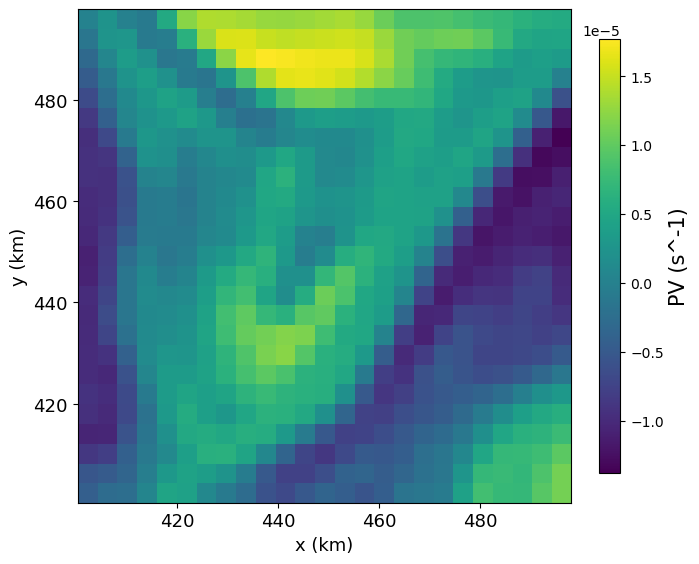

In [41]:
fig = plt.figure(figsize=(7,7))
ax = plt.gca()

#ax.imshow(q0)
img = ax.imshow(q1000.data[inner400[0]:inner400[-1],inner400[0]:inner400[-1]],
    origin='lower', extent=np.array([xval[0], xval[-1], xval[0], xval[-1]])*1e-3)
cbaxes = plt.colorbar(img, pad=0.05, fraction=0.040)
cbaxes.set_label('PV (s^-1)', fontsize=15.)
#
ax.set_xlabel('x (km)')
ax.set_ylabel('y (km)')
#    cbaxes.ax.tick_params(labelsize=csz)
cugn_plotting.set_fontsize(ax, 13)
plt.show()

----

In [32]:
mSF_15.dr[0,:].values*1e-3

array([  2.5,   7.5,  12.5,  17.5,  22.5,  27.5,  32.5,  37.5,  42.5,
        47.5,  52.5,  57.5,  62.5,  67.5,  72.5,  77.5,  82.5,  87.5,
        92.5,  97.5, 102.5, 107.5, 112.5, 117.5, 122.5, 127.5, 132.5,
       137.5, 142.5, 147.5, 152.5, 157.5, 162.5, 167.5, 172.5, 177.5,
       182.5, 187.5, 192.5, 197.5, 202.5, 207.5, 212.5, 217.5, 222.5,
       227.5, 232.5, 237.5, 242.5, 247.5, 252.5, 257.5, 262.5, 267.5,
       272.5, 277.5, 282.5, 287.5, 292.5])

In [43]:
qg.time

<xarray.DataArray 'time' (time: 7200)> Size: 58kB
array([0.000000e+00, 8.640000e+04, 1.728000e+05, ..., 6.218208e+08,
       6.219072e+08, 6.219936e+08])
Coordinates:
  * time     (time) float64 58kB 0.0 8.64e+04 1.728e+05 ... 6.219e+08 6.22e+08
Attributes:
    long_name:  model time
    units:      s

In [44]:
8.64e4 / 24 / 3600

1.0

In [46]:
qg.time.isel(time=1000) / 24/ 3600

<xarray.DataArray 'time' ()> Size: 8B
array(1000.)
Coordinates:
    time     float64 8B 8.64e+07